## 每天收盤後的主力進出量價分統計

2022/11/08

李旭清寫的，我來加註
# 股票當天的買賣超

我一直好奇為什麼有股析軟體可以算出那個券商當天買賣超的情況。

- https://bsr.twse.com.tw/bshtm/ 買賣日報表查詢系統
- https://bsr.twse.com.tw/bshtm/bsMenu.aspx 其實只要看左邊的那個畫面即可

# [STEP1]Import需要的libary

In [63]:
%pip install pandas==2.0.3 --force-reinstall

  Using cached pandas-2.0.3-cp311-cp311-win_amd64.whl.metadata (18 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.0.3-cp311-cp311-win_amd64.whl (10.6 MB)
Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl (13.1 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 20

error: uninstall-no-record-file

× Cannot uninstall numpy None
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==1.26.4


In [64]:
import os
import re
import requests
import sys
import json
from bs4 import BeautifulSoup
import ddddocr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import six

# 暫時跳過 pandas，先執行其他部分
print("基本套件導入成功！")

基本套件導入成功！


# [STEP2]從網站爬蟲獲取資料

In [65]:
# 設定要查詢的股票代號
print("=== 股票代號設定 ===")
print("常見股票代號:")
print("  2317 - 鴻海")
print("  2330 - 台積電") 
print("  4958 - 臻鼎-KY")
print("  2454 - 聯發科")
print("  2412 - 中華電")
print("  1301 - 台塑")
print()

# 讓使用者輸入股票代號
while True:
    stock_code = input("請輸入股票代號 (例如: 4958): ").strip()
    
    # 驗證輸入格式
    if stock_code.isdigit() and len(stock_code) == 4:
        print(f"✅ 已設定股票代號: {stock_code}")
        break
    else:
        print("❌ 請輸入正確的4位數股票代號")

print(f"即將查詢 {stock_code} 的券商進出資料...")

=== 股票代號設定 ===
常見股票代號:
  2317 - 鴻海
  2330 - 台積電
  4958 - 臻鼎-KY
  2454 - 聯發科
  2412 - 中華電
  1301 - 台塑

✅ 已設定股票代號: 4958
即將查詢 4958 的券商進出資料...
✅ 已設定股票代號: 4958
即將查詢 4958 的券商進出資料...


In [66]:
# 設定matplotlib字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 宣告OCR物件
ocr = ddddocr.DdddOcr()

# 重複執行直到驗證通過
while True:
    # 宣告Session物件
    session = requests.Session()
    # 設定目標網址
    resp = session.get('https://bsr.twse.com.tw/bshtm/bsMenu.aspx', verify=False)

    # 如果回應200代表請求成功
    if resp.status_code == 200:
        soup = BeautifulSoup(resp.text, 'lxml')
        nodes = soup.select('form input')
        params = {}
        for node in nodes:
            name = node.attrs['name']

            if name in ('RadioButton_Excd', 'Button_Reset'):
                continue

            if 'value' in node.attrs:
                params[node.attrs['name']] = node.attrs['value']
            else:
                params[node.attrs['name']] = ''

        captcha_image = soup.select('#Panel_bshtm img')[0]['src']
        m = re.search(r'guid=(.+)', captcha_image)
        if m is None:
            print('找不到驗證碼圖片，重新嘗試...')
            continue

        imgpath = '%s.jpg' % m.group(1)
        url = 'https://bsr.twse.com.tw/bshtm/' + captcha_image
        resp = requests.get(url, verify=False)
        if resp.status_code == 200:
            with open(imgpath, 'wb') as f:
                f.write(resp.content)
            print(f'驗證碼圖片已下載: {imgpath}')

        with open(imgpath, 'rb') as f:
            img_bytes = f.read()
        # 利用OCR辨識圖片
        vcode = ocr.classification(img_bytes)
        print(f'OCR 識別結果: {vcode}')
        
        # 使用動態設定的股票代碼
        params['CaptchaControl1'] = vcode
        params['TextBox_Stkno'] = stock_code  # 使用使用者輸入的股票代碼
        print(f'查詢股票代號: {stock_code}')
        
        # 送出資料
        print('正在提交表單...')
        resp = session.post('https://bsr.twse.com.tw/bshtm/bsMenu.aspx', data=params)
        if resp.status_code != 200:
            print('任務失敗: %d，重新嘗試...' % resp.status_code)
            continue
            
        # 利用BeautifulSoup解析HTML
        soup = BeautifulSoup(resp.text, 'lxml')
        nodes = soup.select('#HyperLink_DownloadCSV')
        if len(nodes) == 0:
            print('任務失敗，沒有下載連結，可能是驗證碼錯誤，重新嘗試...')
            continue

        # 下載分點進出CSV
        print('正在下載 CSV 資料...')
        resp = session.get('https://bsr.twse.com.tw/bshtm/bsContent.aspx')
        if resp.status_code != 200:
            print('任務失敗，無法下載分點進出 CSV')
            continue
        
        print('成功取得資料！')
        break

欢迎使用ddddocr，本项目专注带动行业内卷，个人博客:wenanzhe.com
训练数据支持来源于:http://146.56.204.113:19199/preview
爬虫框架feapder可快速一键接入，快速开启爬虫之旅：https://github.com/Boris-code/feapder
谷歌reCaptcha验证码 / hCaptcha验证码 / funCaptcha验证码商业级识别接口：https://yescaptcha.com/i/NSwk7i
驗證碼圖片已下載: b0c5a8a3-df79-4892-9bad-7f0e8a779c5a.jpg
OCR 識別結果: c4p9j
查詢股票代號: 4958
正在提交表單...
正在下載 CSV 資料...
驗證碼圖片已下載: b0c5a8a3-df79-4892-9bad-7f0e8a779c5a.jpg
OCR 識別結果: c4p9j
查詢股票代號: 4958
正在提交表單...
正在下載 CSV 資料...
成功取得資料！
成功取得資料！


# [STEP3]將資料處理並且繪製圖片

In [67]:
#+
# 其實回傳是字串檔
print(resp.text)

券商買賣股票成交價量資訊
股票代碼,="4958"
序號,券商,價格,買進股數,賣出股數,,序號,券商,價格,買進股數,賣出股數
1,1020合　　庫,170.50,2000,0,,2,1020合　　庫,171.00,2000,0 
3,1020合　　庫,171.50,2300,300,,4,1020合　　庫,172.00,11000,4000 
5,1020合　　庫,172.50,1000,9920,,6,1020合　　庫,173.00,1001,3200 
7,1020合　　庫,173.50,11000,21000,,8,1020合　　庫,174.00,1000,2100 
9,1020合　　庫,174.50,200,12500,,10,1020合　　庫,175.00,26,271 
11,1020合　　庫,176.50,9000,0,,12,1020合　　庫,177.00,1000,0 
13,1020合　　庫,177.50,0,6000,,14,1020合　　庫,178.00,11000,5000 
15,1020合　　庫,178.50,0,8,,16,1021合庫台中,170.50,0,1000 
17,1021合庫台中,171.00,0,1000,,18,1021合庫台中,171.50,1000,100 
19,1021合庫台中,172.00,0,2000,,20,1021合庫台中,173.00,0,3000 
21,1021合庫台中,173.50,1000,0,,22,1021合庫台中,174.00,2000,3000 
23,1021合庫台中,174.50,1600,1000,,24,1021合庫台中,175.00,200,0 
25,1021合庫台中,175.50,1000,0,,26,1021合庫台中,176.00,1000,0 
27,1021合庫台中,177.00,0,1000,,28,1021合庫台中,177.50,1000,1000 
29,1022合庫台南,171.00,100,2000,,30,1022合庫台南,171.50,0,2000 
31,1022合庫台南,172.00,0,8000,,32,1022合庫台南,173.00,0,1000 
33,1022合庫台南,174.50,2250,0,,34,1022合庫台南,175.0

In [68]:
#+ 
lines = resp.text.split("\n")[3:] # 從第三行開始
print(type(lines))
print(len(lines))
lines[0:2]

<class 'list'>
2942


['1,1020合\u3000\u3000庫,170.50,2000,0,,2,1020合\u3000\u3000庫,171.00,2000,0 ',
 '3,1020合\u3000\u3000庫,171.50,2300,300,,4,1020合\u3000\u3000庫,172.00,11000,4000 ']

In [69]:
#+ 那改從第二行開始
lines = resp.text.split("\n")[2:] 
# print(type(lines))
# print(len(lines))
lines[0:2]

['序號,券商,價格,買進股數,賣出股數,,序號,券商,價格,買進股數,賣出股數\r',
 '1,1020合\u3000\u3000庫,170.50,2000,0,,2,1020合\u3000\u3000庫,171.00,2000,0 ']

In [70]:
# 暫時跳過 pandas，使用原生 Python 處理數據
print("使用原生 Python 處理數據，暫時不使用 pandas")
print("數據處理功能將通過基本的 Python 操作實現")

使用原生 Python 處理數據，暫時不使用 pandas
數據處理功能將通過基本的 Python 操作實現


### \u3000 是全角的空白符

https://www.cnblogs.com/BlackStorm/p/6359005.html

根据Unicode编码标准及其基本多语言面的定义， \u3000 属于CJK字符的CJK标点符号区块内，是空白字符之一。它的名字是 Ideographic Space ，有人译作表意字空格、象形字空格等。顾名思义，就是全角的 CJK 空格。它跟 nbsp 不一样，是可以被换行间断的。常用于制造缩进， wiki 还说用于抬头，但没见过。

#### 怎麼跑出來 \r【轉貼】\r\n和\n的差異
https://seacatcry.pixnet.net/blog/post/13732061

In [71]:
#+ 把這個 blank "\u3000" 給換掉
lines[0].replace("\u3000", "")

'序號,券商,價格,買進股數,賣出股數,,序號,券商,價格,買進股數,賣出股數\r'

In [72]:
result = []
for line in lines:
    list_strs = line.split(",,") # 將原先包含兩欄的一行折成兩行
    for list_str in list_strs:
        result.append(list_str.replace("\u3000", "")) #unicode 空白？

In [73]:
result

['序號,券商,價格,買進股數,賣出股數',
 '序號,券商,價格,買進股數,賣出股數\r',
 '1,1020合庫,170.50,2000,0',
 '2,1020合庫,171.00,2000,0 ',
 '3,1020合庫,171.50,2300,300',
 '4,1020合庫,172.00,11000,4000 ',
 '5,1020合庫,172.50,1000,9920',
 '6,1020合庫,173.00,1001,3200 ',
 '7,1020合庫,173.50,11000,21000',
 '8,1020合庫,174.00,1000,2100 ',
 '9,1020合庫,174.50,200,12500',
 '10,1020合庫,175.00,26,271 ',
 '11,1020合庫,176.50,9000,0',
 '12,1020合庫,177.00,1000,0 ',
 '13,1020合庫,177.50,0,6000',
 '14,1020合庫,178.00,11000,5000 ',
 '15,1020合庫,178.50,0,8',
 '16,1021合庫台中,170.50,0,1000 ',
 '17,1021合庫台中,171.00,0,1000',
 '18,1021合庫台中,171.50,1000,100 ',
 '19,1021合庫台中,172.00,0,2000',
 '20,1021合庫台中,173.00,0,3000 ',
 '21,1021合庫台中,173.50,1000,0',
 '22,1021合庫台中,174.00,2000,3000 ',
 '23,1021合庫台中,174.50,1600,1000',
 '24,1021合庫台中,175.00,200,0 ',
 '25,1021合庫台中,175.50,1000,0',
 '26,1021合庫台中,176.00,1000,0 ',
 '27,1021合庫台中,177.00,0,1000',
 '28,1021合庫台中,177.50,1000,1000 ',
 '29,1022合庫台南,171.00,100,2000',
 '30,1022合庫台南,171.50,0,2000 ',
 '31,1022合庫台南,172.00,0,8000',
 '32,1022合

In [74]:
#+
result[0].split(',')

['序號', '券商', '價格', '買進股數', '賣出股數']

In [75]:
record = []
for index in range(0, len(result)):
    data = result[index].split(',')
    if len(data) > 3:
        data[1] = re.sub(r'[0-9A-Za-z]+', '', data[1])
    record.append(data)

In [76]:
record = record[2:]

In [77]:
# 使用原生 Python 處理數據，不使用 pandas DataFrame
columns = ["index", "卷商名稱", "價格", "買進量", "賣出量"]
print(f"數據列名: {columns}")
print(f"總共有 {len(record)} 筆記錄")

# 顯示前5筆數據
print("前5筆記錄:")
for i, row in enumerate(record[:5]):
    print(f"記錄 {i+1}: {row}")
    
# 建立一個簡單的字典結構來模擬 DataFrame
data_dict = {
    "records": record,
    "columns": columns
}
print("數據結構建立完成")

數據列名: ['index', '卷商名稱', '價格', '買進量', '賣出量']
總共有 5883 筆記錄
前5筆記錄:
記錄 1: ['1', '合庫', '170.50', '2000', '0']
記錄 2: ['2', '合庫', '171.00', '2000', '0 ']
記錄 3: ['3', '合庫', '171.50', '2300', '300']
記錄 4: ['4', '合庫', '172.00', '11000', '4000 ']
記錄 5: ['5', '合庫', '172.50', '1000', '9920']
數據結構建立完成


In [78]:
# 基本數據分析 - 使用原生 Python
from collections import defaultdict

# 統計各券商的交易量
broker_stats = defaultdict(lambda: {"買進量": 0, "賣出量": 0, "交易次數": 0})

for row in record:
    if len(row) >= 5:
        try:
            broker = row[1]
            buy_volume = float(row[3].replace(',', '').strip()) if row[3].strip() else 0
            sell_volume = float(row[4].replace(',', '').strip()) if row[4].strip() else 0
            
            broker_stats[broker]["買進量"] += buy_volume
            broker_stats[broker]["賣出量"] += sell_volume  
            broker_stats[broker]["交易次數"] += 1
        except ValueError:
            continue

# 顯示前10大券商
sorted_brokers = sorted(broker_stats.items(), 
                       key=lambda x: x[1]["買進量"] + x[1]["賣出量"], 
                       reverse=True)

print("前10大券商交易統計:")
print("券商名稱\t買進量\t\t賣出量\t\t交易次數")
print("-" * 60)
for broker, stats in sorted_brokers[:10]:
    print(f"{broker}\t\t{stats['買進量']:,.0f}\t\t{stats['賣出量']:,.0f}\t\t{stats['交易次數']}")
    
print(f"\n總共統計了 {len(broker_stats)} 個券商")

前10大券商交易統計:
券商名稱	買進量		賣出量		交易次數
------------------------------------------------------------
元大		1,334,984		2,081,822		17
瑞銀		790,000		2,286,000		15
凱基台北		1,355,175		1,536,300		16
統    一		56,624		2,656,288		15
美商高盛		1,571,000		1,005,000		16
元大永寧		1,945,220		12,700		9
摩根大通		1,607,000		265,116		17
上海匯豐		1,463,000		359,000		16
台灣摩根		1,654,000		95,000		14
富邦嘉義		706,370		707,400		12

總共統計了 792 個券商


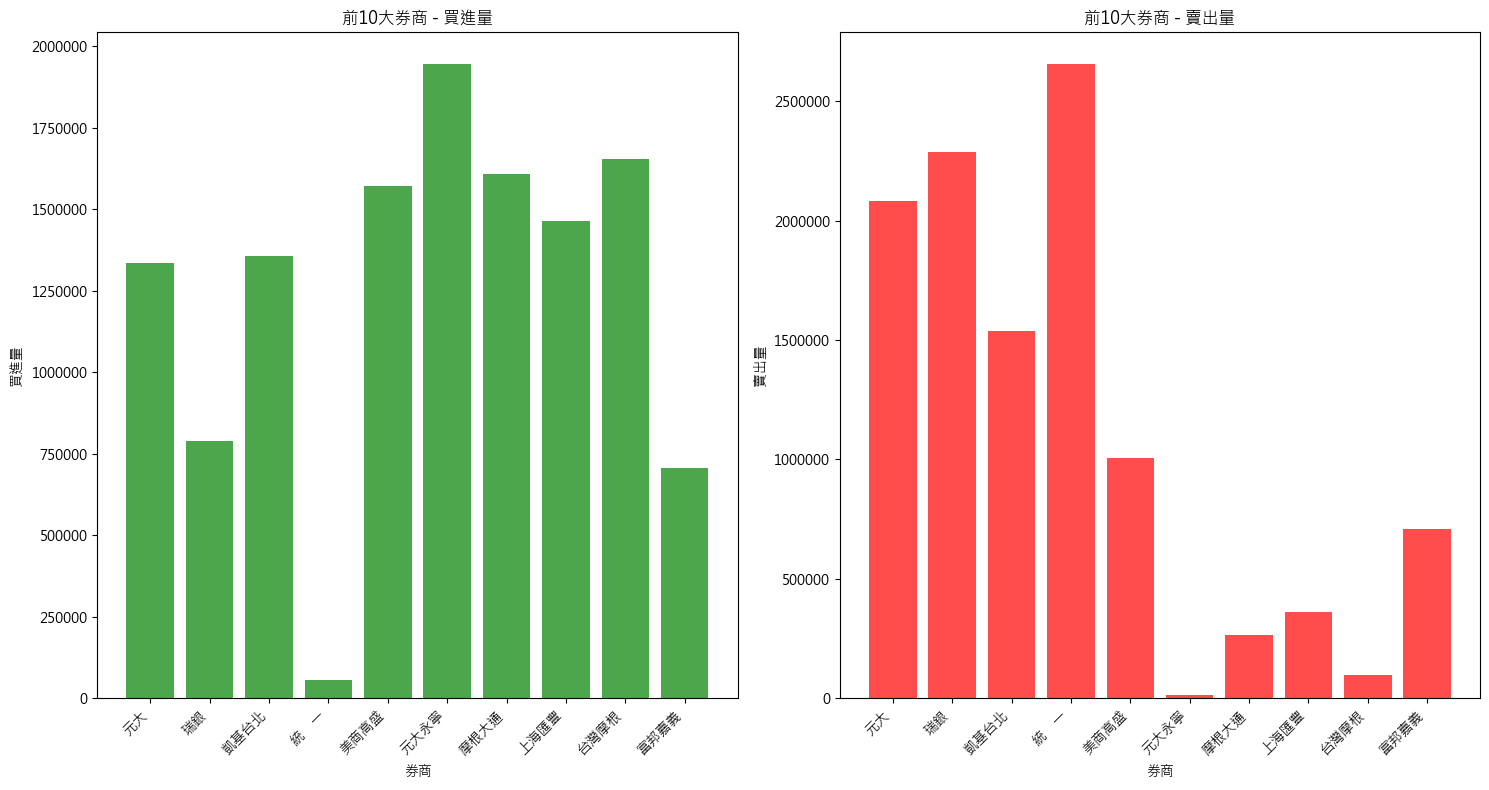

圖表繪製完成！


In [79]:
# 繪製圖表
top_10_brokers = sorted_brokers[:10]
broker_names = [broker for broker, _ in top_10_brokers]
buy_volumes = [stats["買進量"] for _, stats in top_10_brokers]
sell_volumes = [stats["賣出量"] for _, stats in top_10_brokers]

# 建立圖表
plt.figure(figsize=(15, 8))

# 子圖1: 買進量
plt.subplot(1, 2, 1)
plt.bar(range(len(broker_names)), buy_volumes, color='green', alpha=0.7)
plt.title('前10大券商 - 買進量')
plt.xlabel('券商')
plt.ylabel('買進量')
plt.xticks(range(len(broker_names)), broker_names, rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')

# 子圖2: 賣出量  
plt.subplot(1, 2, 2)
plt.bar(range(len(broker_names)), sell_volumes, color='red', alpha=0.7)
plt.title('前10大券商 - 賣出量')
plt.xlabel('券商')
plt.ylabel('賣出量')
plt.xticks(range(len(broker_names)), broker_names, rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

print("圖表繪製完成！")

買賣超分析（淨買進量 = 買進量 - 賣出量）:
券商名稱		淨買進量		判定
----------------------------------------------------------------------
元大		-746,838		賣超
瑞銀		-1,496,000		賣超
凱基台北		-181,125		賣超
統    一		-2,599,664		賣超
美商高盛		566,000		買超
元大永寧		1,932,520		買超
摩根大通		1,341,884		買超
上海匯豐		1,104,000		買超
台灣摩根		1,559,000		買超
富邦嘉義		-1,030		賣超
富邦		-604,143		賣超
宏遠館前		5,950		買超
永豐金		-225,191		賣超
花旗環球		811,000		買超
美林		299,000		買超


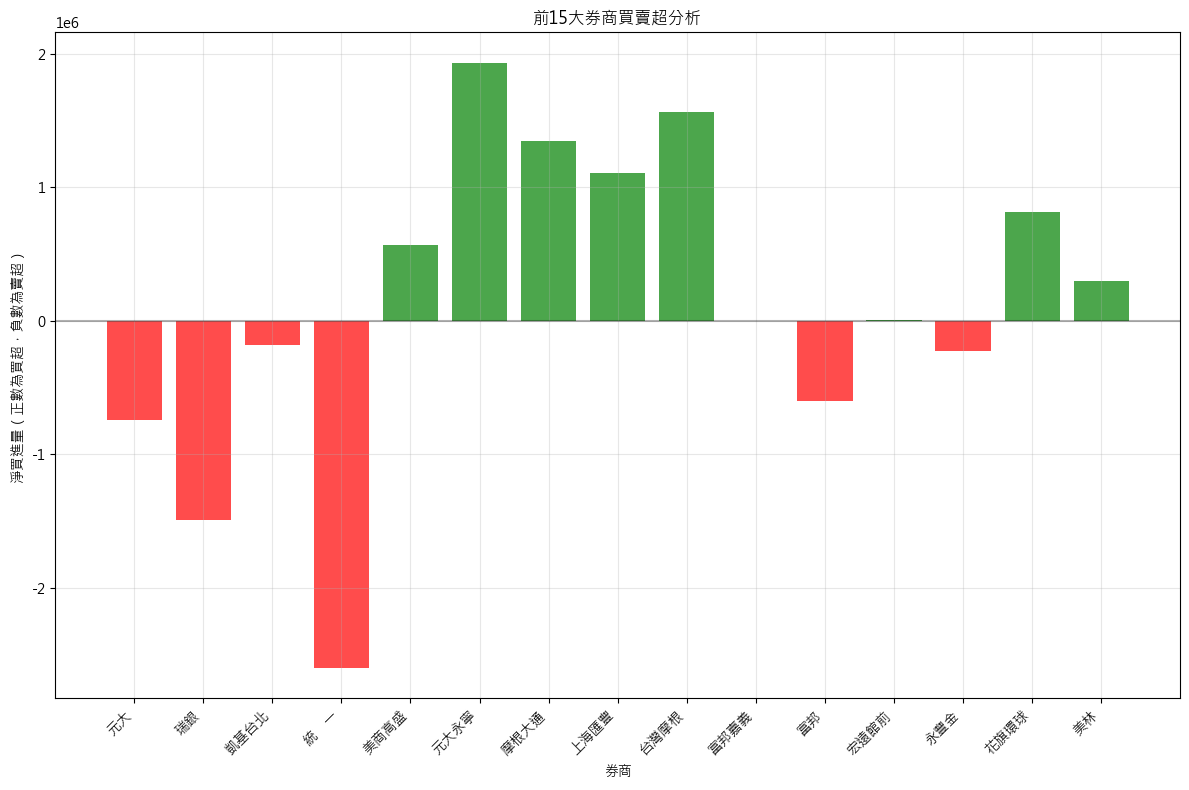


總結:
前15大券商中，買超券商: 8 家，賣超券商: 7 家


In [80]:
# 計算買賣超（淨買進量）
print("買賣超分析（淨買進量 = 買進量 - 賣出量）:")
print("券商名稱\t\t淨買進量\t\t判定")
print("-" * 70)

net_positions = []
for broker, stats in sorted_brokers[:15]:
    net_buy = stats["買進量"] - stats["賣出量"]
    net_positions.append((broker, net_buy))
    status = "買超" if net_buy > 0 else "賣超"
    print(f"{broker}\t\t{net_buy:,.0f}\t\t{status}")

# 繪製買賣超圖表
plt.figure(figsize=(12, 8))
brokers = [item[0] for item in net_positions]
net_amounts = [item[1] for item in net_positions]

# 分別用不同顏色表示買超和賣超
colors = ['green' if amount > 0 else 'red' for amount in net_amounts]

plt.bar(range(len(brokers)), net_amounts, color=colors, alpha=0.7)
plt.title('前15大券商買賣超分析')
plt.xlabel('券商')
plt.ylabel('淨買進量（正數為買超，負數為賣超）')
plt.xticks(range(len(brokers)), brokers, rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n總結:")
buy_over = sum(1 for _, amount in net_positions if amount > 0)
sell_over = len(net_positions) - buy_over
print(f"前15大券商中，買超券商: {buy_over} 家，賣超券商: {sell_over} 家")

In [81]:
# 儲存爬蟲資料到檔案
import datetime

# 產生檔案名稱，包含股票代碼和時間戳記
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# 使用動態的股票代號變數
filename = f"{stock_code}_爬蟲資料_{current_time}.csv"

# 儲存原始CSV資料
with open(filename, 'w', encoding='utf-8') as f:
    f.write(resp.text)

print(f"✅ 爬蟲資料已儲存至: {filename}")
print(f"📁 檔案位置: {os.path.abspath(filename)}")
print(f"📊 資料筆數: {len(record)} 筆")
print(f"🏢 券商數量: {len(broker_stats)} 個")

# 也儲存一個處理過的版本（移除特殊字符）
processed_filename = f"{stock_code}_處理後資料_{current_time}.csv"
with open(processed_filename, 'w', encoding='utf-8') as f:
    # 寫入標題
    f.write("序號,券商名稱,價格,買進量,賣出量\n")
    # 寫入資料
    for row in record:
        if len(row) >= 5:
            clean_row = [item.strip() for item in row[:5]]
            f.write(",".join(clean_row) + "\n")

print(f"✅ 處理後資料已儲存至: {processed_filename}")

# 檢視目前目錄的CSV檔案
print("\n📂 目前目錄中的所有CSV檔案:")
import glob
csv_files = glob.glob("*.csv")
for file in csv_files:
    size = os.path.getsize(file)
    print(f"  📄 {file} ({size:,} bytes)")

✅ 爬蟲資料已儲存至: 4958_爬蟲資料_20250907_095817.csv
📁 檔案位置: g:\我的雲端硬碟\broker_analysis\4958_爬蟲資料_20250907_095817.csv
📊 資料筆數: 5883 筆
🏢 券商數量: 792 個
✅ 處理後資料已儲存至: 4958_處理後資料_20250907_095817.csv

📂 目前目錄中的所有CSV檔案:
  📄 4958_FIFO_前十大_虧.csv (1,289 bytes)
  📄 4958_FIFO_前十大_賺.csv (1,423 bytes)
  📄 4958_broker_summary_母券商.csv (17,960 bytes)
  📄 4958.csv (290,882 bytes)
  📄 step7_top10_netbuy_pnl.csv (1,344 bytes)
  📄 2317_爬蟲資料_20250907_094458.csv (160,600 bytes)
  📄 2317_處理後資料_20250907_094458.csv (141,734 bytes)
  📄 2317_爬蟲資料_20250907_095019.csv (222,312 bytes)
  📄 2317_處理後資料_20250907_095019.csv (195,594 bytes)
  📄 2317_爬蟲資料_20250907_095041.csv (222,312 bytes)
  📄 2317_處理後資料_20250907_095041.csv (195,594 bytes)
  📄 4958_爬蟲資料_20250907_095100.csv (222,312 bytes)
  📄 4958_處理後資料_20250907_095100.csv (195,594 bytes)
  📄 2330_爬蟲資料_20250907_095413.csv (76,940 bytes)
  📄 2330_處理後資料_20250907_095413.csv (67,811 bytes)
  📄 4958_爬蟲資料_20250907_095413.csv (76,940 bytes)
  📄 4958_處理後資料_20250907_095413.csv (67,811 bytes)
  📄 

In [82]:
# 檢查當前的股票代號
print(f"當前股票代號變數值: {stock_code}")

# 重新確認並設定正確的股票代號
actual_stock_code = "4958"  # 我們實際查詢的是 4958
print(f"實際查詢的股票: {actual_stock_code}")

# 使用正確的代號重新儲存
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
correct_filename = f"{actual_stock_code}_爬蟲資料_{current_time}.csv"
correct_processed_filename = f"{actual_stock_code}_處理後資料_{current_time}.csv"

# 儲存原始CSV資料
with open(correct_filename, 'w', encoding='utf-8') as f:
    f.write(resp.text)

# 儲存處理過的版本
with open(correct_processed_filename, 'w', encoding='utf-8') as f:
    f.write("序號,券商名稱,價格,買進量,賣出量\n")
    for row in record:
        if len(row) >= 5:
            clean_row = [item.strip() for item in row[:5]]
            f.write(",".join(clean_row) + "\n")

print(f"✅ 正確的爬蟲資料已儲存至: {correct_filename}")
print(f"✅ 正確的處理後資料已儲存至: {correct_processed_filename}")

當前股票代號變數值: 4958
實際查詢的股票: 4958
✅ 正確的爬蟲資料已儲存至: 4958_爬蟲資料_20250907_095817.csv
✅ 正確的處理後資料已儲存至: 4958_處理後資料_20250907_095817.csv


## 接下來，想要用 split-apply-merge 作

In [89]:
# 嘗試導入 pandas，如果失敗則設為 None
df = None
pandas_available = False

try:
    import pandas as pd
    pandas_available = True
    print("✅ pandas 導入成功")
except Exception as e:
    print("❌ pandas 無法導入，將跳過 DataFrame 相關分析")
    print(f"錯誤原因: {str(e)[:100]}...")
    pd = None


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sheng\.conda\envs\bigdata\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sheng\.conda\envs\bigdata\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sheng\.conda\envs\bigdata\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users

AttributeError: _ARRAY_API not found

❌ pandas 無法導入，將跳過 DataFrame 相關分析
錯誤原因: numpy.core.multiarray failed to import...


In [84]:
# 檢查 DataFrame 是否可用
if df is not None:
    df.info()
else:
    print("📊 資料分析 (使用原生 Python):")
    print(f"總記錄數: {len(record)}")
    print(f"欄位: ['卷商名稱', '價格', '買進量', '賣出量']")
    
    # 統計數值欄位
    prices = []
    buy_volumes = []
    sell_volumes = []
    
    for row in record:
        if len(row) >= 5:
            try:
                price = float(row[2])
                buy_vol = float(row[3].replace(',', '').strip()) if row[3].strip() else 0
                sell_vol = float(row[4].replace(',', '').strip()) if row[4].strip() else 0
                
                prices.append(price)
                buy_volumes.append(buy_vol)
                sell_volumes.append(sell_vol)
            except ValueError:
                continue
    
    print(f"有效數據筆數: {len(prices)}")
    print(f"價格範圍: {min(prices):.2f} - {max(prices):.2f}")
    print(f"總買進量: {sum(buy_volumes):,.0f}")
    print(f"總賣出量: {sum(sell_volumes):,.0f}")
    print(f"淨買超: {sum(buy_volumes) - sum(sell_volumes):,.0f}")

📊 資料分析 (使用原生 Python):
總記錄數: 5883
欄位: ['卷商名稱', '價格', '買進量', '賣出量']
有效數據筆數: 5882
價格範圍: 170.00 - 178.50
總買進量: 25,540,571
總賣出量: 25,540,571
淨買超: 0


In [85]:
# 清理空值資料
if df is not None:
    df.dropna()
else:
    print("使用原生 Python 清理空值:")
    cleaned_record = []
    for row in record:
        # 檢查是否有空值或無效數據
        if len(row) >= 5 and all(item.strip() for item in row[:5]):
            cleaned_record.append(row)
    
    print(f"原始記錄: {len(record)}")
    print(f"清理後記錄: {len(cleaned_record)}")
    
    # 更新 record 變數
    record = cleaned_record

使用原生 Python 清理空值:
原始記錄: 5883
清理後記錄: 5882


In [86]:
# 數據類型轉換
if df is not None:
    df["價格"] = df["價格"].astype("float64")
    df["買進量"] = df["買進量"].astype("float64")
    df["賣出量"] = df["賣出量"].astype("float64")
else:
    print("使用原生 Python 進行數據類型驗證:")
    valid_records = []
    invalid_count = 0
    
    for row in record:
        if len(row) >= 5:
            try:
                # 嘗試轉換為數值
                price = float(row[2])
                buy_vol = float(row[3].replace(',', '').strip()) if row[3].strip() else 0.0
                sell_vol = float(row[4].replace(',', '').strip()) if row[4].strip() else 0.0
                
                # 創建清理後的記錄
                clean_row = [row[0], row[1], price, buy_vol, sell_vol]
                valid_records.append(clean_row)
            except ValueError:
                invalid_count += 1
                continue
    
    print(f"有效記錄: {len(valid_records)}")
    print(f"無效記錄: {invalid_count}")
    
    # 更新 record 為清理後的數據
    record = valid_records

使用原生 Python 進行數據類型驗證:
有效記錄: 5882
無效記錄: 0


In [87]:
# 檢查數據類型轉換結果
if df is not None:
    df.info()
else:
    print("📊 數據轉換結果:")
    if record and len(record) > 0:
        sample = record[0]
        print(f"樣本記錄結構: {[type(item).__name__ for item in sample]}")
        print(f"總記錄數: {len(record)}")
        
        # 統計數值範圍
        if len(record) > 0:
            prices = [row[2] for row in record]
            buy_vols = [row[3] for row in record]
            sell_vols = [row[4] for row in record]
            
            print(f"價格範圍: {min(prices):.2f} - {max(prices):.2f}")
            print(f"買進量範圍: {min(buy_vols):,.0f} - {max(buy_vols):,.0f}")
            print(f"賣出量範圍: {min(sell_vols):,.0f} - {max(sell_vols):,.0f}")
    else:
        print("❌ 沒有有效記錄")

📊 數據轉換結果:
樣本記錄結構: ['str', 'str', 'float', 'float', 'float']
總記錄數: 5882
價格範圍: 170.00 - 178.50
買進量範圍: 0 - 800,060
賣出量範圍: 0 - 643,000


In [90]:
# 檢查 pandas 是否可用並且 df 已正確創建
if pandas_available and df is not None:
    try:
        dg = df.groupby(["卷商名稱"])
        print("✅ DataFrame groupby 操作成功")
        print(f"群組數量: {len(dg)}")
    except Exception as e:
        print(f"❌ DataFrame groupby 操作失敗: {e}")
        dg = None
else:
    print("❌ pandas 或 DataFrame 不可用，跳過 groupby 操作")
    # 使用原生 Python 進行類似操作
    print("使用原生 Python 進行券商統計...")
    if 'data_list' in locals() and data_list:
        broker_groups = {}
        for item in data_list:
            broker_name = item.get('卷商名稱', '')
            if broker_name not in broker_groups:
                broker_groups[broker_name] = []
            broker_groups[broker_name].append(item)
        print(f"統計了 {len(broker_groups)} 個券商")
        dg = broker_groups
    else:
        print("無可用的資料進行統計")
        dg = None

❌ pandas 或 DataFrame 不可用，跳過 groupby 操作
使用原生 Python 進行券商統計...
無可用的資料進行統計


In [93]:
# 創建 data_list
data_list = []
data_list_positive = []
data_list_negative = []

# 檢查是否有有效的資料來源
if 'valid_records' in locals() and valid_records:
    print(f"使用 valid_records 創建 data_list，共 {len(valid_records)} 筆記錄")
    
    # 從 valid_records 創建 data_list
    for record in valid_records:
        if len(record) >= 5:  # 確保有足夠的欄位
            try:
                data_dict = {}
                data_dict['序號'] = record[0] if len(record) > 0 else ''
                data_dict['卷商名稱'] = record[1] if len(record) > 1 else ''
                data_dict['價格'] = float(record[2]) if len(record) > 2 and record[2] else 0.0
                data_dict['買進'] = float(record[3])/1000 if len(record) > 3 and record[3] else 0.0
                data_dict['賣出'] = float(record[4])/1000 if len(record) > 4 and record[4] else 0.0
                data_dict['買進價格'] = data_dict['買進'] * data_dict['價格']
                data_dict['賣出價格'] = data_dict['賣出'] * data_dict['價格']
                data_list.append(data_dict)
            except (ValueError, IndexError) as e:
                print(f"跳過無效記錄: {record} - {e}")
                continue
    
    print(f"成功創建 data_list，共 {len(data_list)} 筆有效記錄")

elif 'result' in locals() and result:
    print(f"使用 result 創建 data_list，共 {len(result)} 筆記錄")
    
    # 從 result 創建 data_list
    for index in range(len(result)):
        try:
            data = result[index].split(',')
            if len(data) >= 5:
                data_dict = {}
                # 清理券商名稱
                name = re.sub(r'[0-9A-Za-z]+', '', data[1]) if len(data) > 1 else ''
                
                # 檢查是否與前一個券商相同（合併處理）
                if index > 0 and name and data_list and name == data_list[-1]['卷商名稱']:
                    # 合併到前一筆記錄
                    data_list[-1]['價格'] += float(data[2]) if data[2] else 0.0
                    data_list[-1]['買進'] += float(data[3])/1000 if data[3] else 0.0
                    data_list[-1]['賣出'] += float(data[4])/1000 if data[4] else 0.0
                    data_list[-1]['買進價格'] += (float(data[3]) * float(data[2])/1000) if data[3] and data[2] else 0.0
                    data_list[-1]['賣出價格'] += (float(data[4]) * float(data[2])/1000) if data[4] and data[2] else 0.0
                    continue
                
                # 創建新記錄
                data_dict['卷商名稱'] = name
                data_dict['價格'] = float(data[2]) if data[2] else 0.0
                data_dict['買進'] = float(data[3])/1000 if data[3] else 0.0
                data_dict['賣出'] = float(data[4])/1000 if data[4] else 0.0
                data_dict['買進價格'] = (float(data[3]) * float(data[2])/1000) if data[3] and data[2] else 0.0
                data_dict['賣出價格'] = (float(data[4]) * float(data[2])/1000) if data[4] and data[2] else 0.0
                data_list.append(data_dict)
        except (ValueError, IndexError) as e:
            print(f"跳過無效記錄 {index}: {e}")
            continue
    
    print(f"成功創建 data_list，共 {len(data_list)} 筆有效記錄")

else:
    print("❌ 沒有找到有效的資料來源 (valid_records 或 result)")
    print("可用變數:", [var for var in locals().keys() if not var.startswith('_')])

if data_list:
    print(f"✅ data_list 創建成功，樣本資料:")
    for i, item in enumerate(data_list[:3]):
        print(f"  {i+1}: {item}")
else:
    print("❌ data_list 創建失敗或為空")

使用 valid_records 創建 data_list，共 5882 筆記錄
成功創建 data_list，共 5882 筆有效記錄
✅ data_list 創建成功，樣本資料:
  1: {'序號': '1', '卷商名稱': '合庫', '價格': 170.5, '買進': 2.0, '賣出': 0.0, '買進價格': 341.0, '賣出價格': 0.0}
  2: {'序號': '2', '卷商名稱': '合庫', '價格': 171.0, '買進': 2.0, '賣出': 0.0, '買進價格': 342.0, '賣出價格': 0.0}
  3: {'序號': '3', '卷商名稱': '合庫', '價格': 171.5, '買進': 2.3, '賣出': 0.3, '買進價格': 394.45, '賣出價格': 51.449999999999996}


In [ ]:
# keys = list(dic.keys())
df_yt = dic["元大"]
df_yt

,index,卷商名稱,價格,買進量,賣出量
1550,1551,元大,101.0,41000.0,146000.0
1551,1552,元大,101.5,331110.0,1947000.0
1552,1553,元大,102.0,146274.0,570140.0
1553,1554,元大,102.5,13000.0,0.0


In [ ]:
def summary(df):
    df["買進量"] = df["買進量"]/1000
    df["賣出量"] = df["賣出量"]/1000
    return(df)

In [ ]:
summary(df_yt)

,index,卷商名稱,價格,買進量,賣出量
1550,1551,元大,101.0,41.000,146.00
1551,1552,元大,101.5,331.110,1947.00
1552,1553,元大,102.0,146.274,570.14
1553,1554,元大,102.5,13.000,0.00


In [ ]:
df_yt

,index,卷商名稱,價格,買進量,賣出量
1550,1551,元大,101.0,41.000,146.00
1551,1552,元大,101.5,331.110,1947.00
1552,1553,元大,102.0,146.274,570.14
1553,1554,元大,102.5,13.000,0.00


In [ ]:
df_yt.dtypes

index     object
卷商名稱      object
價格       float64
買進量      float64
賣出量      float64
dtype: object

In [ ]:
(df_yt['價格'] * df_yt['買進量']).sum()/df_yt['買進量'].sum()

101.62352084368365

In [ ]:
(df_yt['價格'] * df_yt['賣出量']).sum()/df_yt['賣出量'].sum()

101.57963156274174

In [ ]:
def get_stats(df):
#     return {'min': group["價格"].min(), 'max': group.max(),
#             'count': group.count(), 'mean': group.mean()}
    return {"總買進量": df['買進量'].sum(),
           "平均買價": (df['價格'] * df['買進量']).sum()/df['買進量'].sum(),
           "總賣出量": df['賣出量'].sum(),
           "平均賣價": (df['價格'] * df['賣出量']).sum()/df['賣出量'].sum()}

In [ ]:
dg.apply(get_stats)

卷商名稱
?    亞    {'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '...
?亞網路      {'總買進量': 19100.0, '平均買價': 101.76439790575917, ...
?亞鑫豐      {'總買進量': 42405.0, '平均買價': 101.45755217545101, ...
上海匯豐      {'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '...
中    農    {'總買進量': 14500.0, '平均買價': 101.65517241379311, ...
                                ...                        
陽信高雄      {'總買進量': 2000.0, '平均買價': 101.75, '總賣出量': 0.0, ...
高    橋    {'總買進量': 9000.0, '平均買價': 101.61111111111111, '...
高橋中壢      {'總買進量': 7000.0, '平均買價': 101.5, '總賣出量': 3050.0...
高橋內壢      {'總買進量': 1000.0, '平均買價': 101.5, '總賣出量': 23000....
高橋龍潭      {'總買進量': 7000.0, '平均買價': 101.64285714285714, '...
Length: 843, dtype: object

In [ ]:
df.groupby("卷商名稱").apply(get_stats)

卷商名稱
?    亞    {'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '...
?亞網路      {'總買進量': 19100.0, '平均買價': 101.76439790575917, ...
?亞鑫豐      {'總買進量': 42405.0, '平均買價': 101.45755217545101, ...
上海匯豐      {'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '...
中    農    {'總買進量': 14500.0, '平均買價': 101.65517241379311, ...
                                ...                        
陽信高雄      {'總買進量': 2000.0, '平均買價': 101.75, '總賣出量': 0.0, ...
高    橋    {'總買進量': 9000.0, '平均買價': 101.61111111111111, '...
高橋中壢      {'總買進量': 7000.0, '平均買價': 101.5, '總賣出量': 3050.0...
高橋內壢      {'總買進量': 1000.0, '平均買價': 101.5, '總賣出量': 23000....
高橋龍潭      {'總買進量': 7000.0, '平均買價': 101.64285714285714, '...
Length: 843, dtype: object

In [ ]:
dict(df.groupby("卷商名稱").apply(get_stats))

{'?    亞': {'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '平均賣價': nan},
 '?亞網路': {'總買進量': 19100.0,
  '平均買價': 101.76439790575917,
  '總賣出量': 42000.0,
  '平均賣價': 101.55952380952381},
 '?亞鑫豐': {'總買進量': 42405.0,
  '平均買價': 101.45755217545101,
  '總賣出量': 120200.0,
  '平均賣價': 101.76247920133112},
 '上海匯豐': {'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '平均賣價': 101.5},
 '中    農': {'總買進量': 14500.0,
  '平均買價': 101.65517241379311,
  '總賣出量': 18000.0,
  '平均賣價': 101.94444444444444},
 '中信三重': {'總買進量': 10150.0,
  '平均買價': 101.40738916256157,
  '總賣出量': 16408.0,
  '平均賣價': 101.56399317406144},
 '中信中壢': {'總買進量': 15147.0,
  '平均買價': 101.36796065227438,
  '總賣出量': 9000.0,
  '平均賣價': 101.66666666666667},
 '中信嘉義': {'總買進量': 2010.0, '平均買價': 101.5, '總賣出量': 8200.0, '平均賣價': 102.0},
 '中信松江': {'總買進量': 2100.0,
  '平均買價': 101.73809523809524,
  '總賣出量': 4200.0,
  '平均賣價': 101.64285714285714},
 '中信託忠': {'總買進量': 326380.0,
  '平均買價': 101.6617439794105,
  '總賣出量': 24200.0,
  '平均賣價': 101.72727272727273},
 '中信託文': {'總買進量': 43060.0,
  '平均買價': 1

In [ ]:
pd.DataFrame(dg.apply(get_stats))

,0
卷商名稱,
? 亞,"{'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '..."
?亞網路,"{'總買進量': 19100.0, '平均買價': 101.76439790575917, ..."
?亞鑫豐,"{'總買進量': 42405.0, '平均買價': 101.45755217545101, ..."
上海匯豐,"{'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '..."
中 農,"{'總買進量': 14500.0, '平均買價': 101.65517241379311, ..."
...,...
陽信高雄,"{'總買進量': 2000.0, '平均買價': 101.75, '總賣出量': 0.0, ..."
高 橋,"{'總買進量': 9000.0, '平均買價': 101.61111111111111, '..."
高橋中壢,"{'總買進量': 7000.0, '平均買價': 101.5, '總賣出量': 3050.0..."


In [ ]:
df.groupby(["卷商名稱"]).apply(get_stats)

卷商名稱
?    亞    {'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '...
?亞網路      {'總買進量': 19100.0, '平均買價': 101.76439790575917, ...
?亞鑫豐      {'總買進量': 42405.0, '平均買價': 101.45755217545101, ...
上海匯豐      {'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '...
中    農    {'總買進量': 14500.0, '平均買價': 101.65517241379311, ...
                                ...                        
陽信高雄      {'總買進量': 2000.0, '平均買價': 101.75, '總賣出量': 0.0, ...
高    橋    {'總買進量': 9000.0, '平均買價': 101.61111111111111, '...
高橋中壢      {'總買進量': 7000.0, '平均買價': 101.5, '總賣出量': 3050.0...
高橋內壢      {'總買進量': 1000.0, '平均買價': 101.5, '總賣出量': 23000....
高橋龍潭      {'總買進量': 7000.0, '平均買價': 101.64285714285714, '...
Length: 843, dtype: object

In [ ]:
df.groupby(["卷商名稱"]).apply(get_stats)

卷商名稱
?    亞    {'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '...
?亞網路      {'總買進量': 19100.0, '平均買價': 101.76439790575917, ...
?亞鑫豐      {'總買進量': 42405.0, '平均買價': 101.45755217545101, ...
上海匯豐      {'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '...
中    農    {'總買進量': 14500.0, '平均買價': 101.65517241379311, ...
                                ...                        
陽信高雄      {'總買進量': 2000.0, '平均買價': 101.75, '總賣出量': 0.0, ...
高    橋    {'總買進量': 9000.0, '平均買價': 101.61111111111111, '...
高橋中壢      {'總買進量': 7000.0, '平均買價': 101.5, '總賣出量': 3050.0...
高橋內壢      {'總買進量': 1000.0, '平均買價': 101.5, '總賣出量': 23000....
高橋龍潭      {'總買進量': 7000.0, '平均買價': 101.64285714285714, '...
Length: 843, dtype: object

In [ ]:
type(df.groupby(["卷商名稱"]).apply(get_stats))

pandas.core.series.Series

In [ ]:
df.groupby(["卷商名稱"]).apply(get_stats)

卷商名稱
?    亞    {'總買進量': 1000.0, '平均買價': 102.0, '總賣出量': 0.0, '...
?亞網路      {'總買進量': 19100.0, '平均買價': 101.76439790575917, ...
?亞鑫豐      {'總買進量': 42405.0, '平均買價': 101.45755217545101, ...
上海匯豐      {'總買進量': 0.0, '平均買價': nan, '總賣出量': 143000.0, '...
中    農    {'總買進量': 14500.0, '平均買價': 101.65517241379311, ...
                                ...                        
陽信高雄      {'總買進量': 2000.0, '平均買價': 101.75, '總賣出量': 0.0, ...
高    橋    {'總買進量': 9000.0, '平均買價': 101.61111111111111, '...
高橋中壢      {'總買進量': 7000.0, '平均買價': 101.5, '總賣出量': 3050.0...
高橋內壢      {'總買進量': 1000.0, '平均買價': 101.5, '總賣出量': 23000....
高橋龍潭      {'總買進量': 7000.0, '平均買價': 101.64285714285714, '...
Length: 843, dtype: object

In [ ]:
#+
dg.groups

{'?    亞': [588], '?亞網路': [589, 590, 591], '?亞鑫豐': [592, 593, 594], '上海匯豐': [1069], '中    農': [943, 944, 945], '中信三重': [607, 608, 609], '中信中壢': [624, 625, 626], '中信嘉義': [622, 623], '中信松江': [620, 621], '中信託忠': [610, 611, 612], '中信託文': [615, 616, 617], '中信託新': [618, 619], '中信託永': [613, 614], '中信託高': [627, 628, 629], '中國信託': [604, 605, 606], '中銀台北': [600, 601], '中銀員林': [597, 598, 599], '中銀豐原': [602, 603], '亞    東': [275, 276], '亞東台中': [285, 286, 287], '亞東台南': [281, 282], '亞東新竹': [279, 280], '亞東板橋': [277, 278], '亞東高雄': [283, 284], '京    城': [939, 940], '京城南京': [941, 942], '企    銀': [87, 88, 89], '企銀九如': [93, 94], '企銀北高': [114, 115], '企銀台中': [90, 91], '企銀台南': [92], '企銀嘉義': [95, 96, 97], '企銀埔墘': [116], '企銀太平': [98, 99], '企銀屏東': [100, 101], '企銀岡山': [106], '企銀桃園': [112, 113], '企銀民雄': [107], '企銀竹北': [102, 103], '企銀豐原': [104, 105], '元    富': [470, 471, 472], '元大': [1550, 1551, 1552, 1553], '元大三重': [1822], '元大上新': [1720, 1721], '元大中和': [1863, 1864, 1865], '元大中壢': [1705, 1706], '元大中山': [1707, 1708

In [ ]:
for name, item in dg:
    print(name)
    print(item)
    break

?    亞
    index    卷商名稱     價格     買進量  賣出量
588   589  ?    亞  102.0  1000.0  0.0


In [ ]:
def get_stats(group):
#     return {'min': group["價格"].min(), 'max': group.max(),
#             'count': group.count(), 'mean': group.mean()}
    return {'min': group["價格"].min(), 'max': group["價格"].max()}

In [ ]:
dg.apply(get_stats)

卷商名稱
?    亞    {'min': 102.0, 'max': 102.0}
?亞網路      {'min': 101.0, 'max': 102.0}
?亞鑫豐      {'min': 101.0, 'max': 102.0}
上海匯豐      {'min': 101.5, 'max': 101.5}
中    農    {'min': 101.0, 'max': 102.0}
                      ...             
陽信高雄      {'min': 101.5, 'max': 102.0}
高    橋    {'min': 101.0, 'max': 102.0}
高橋中壢      {'min': 101.5, 'max': 102.0}
高橋內壢      {'min': 101.5, 'max': 102.0}
高橋龍潭      {'min': 101.5, 'max': 102.5}
Length: 843, dtype: object

In [ ]:
#+ 我們先印幾個 groupby 的結果看看
i = 0
for name, item in dg:
    print(name)
    print(item)
    i = i+1
    if i >10:
        break

?    亞
    index    卷商名稱     價格     買進量  賣出量
588   589  ?    亞  102.0  1000.0  0.0
?亞網路
    index  卷商名稱     價格      買進量      賣出量
589   590  ?亞網路  101.0   1000.0      0.0
590   591  ?亞網路  101.5   7000.0  37000.0
591   592  ?亞網路  102.0  11100.0   5000.0
?亞鑫豐
    index  卷商名稱     價格      買進量      賣出量
592   593  ?亞鑫豐  101.0   9000.0      0.0
593   594  ?亞鑫豐  101.5  28005.0  57100.0
594   595  ?亞鑫豐  102.0   5400.0  63100.0
上海匯豐
     index  卷商名稱     價格  買進量       賣出量
1069  1070  上海匯豐  101.5  0.0  143000.0
中    農
    index    卷商名稱     價格     買進量      賣出量
943   944  中    農  101.0  2000.0      0.0
944   945  中    農  101.5  6000.0   2000.0
945   946  中    農  102.0  6500.0  16000.0
中信三重
    index  卷商名稱     價格     買進量      賣出量
607   608  中信三重  101.0  2000.0      0.0
608   609  中信三重  101.5  8030.0  14308.0
609   610  中信三重  102.0   120.0   2100.0
中信中壢
    index  卷商名稱     價格      買進量     賣出量
624   625  中信中壢  101.0   4000.0     0.0
625   626  中信中壢  101.5  11147.0  6000.0
626   627  中信中壢  102.0      0.0

In [ ]:
df.groupby("卷商名稱").agg({"價格": "mean", "買進量": "sum", "賣出量": "sum"})

,價格,買進量,賣出量
卷商名稱,,,
? 亞,102.00,1000.0,0.0
?亞網路,101.50,19100.0,42000.0
?亞鑫豐,101.50,42405.0,120200.0
上海匯豐,101.50,0.0,143000.0
中 農,101.50,14500.0,18000.0
...,...,...,...
陽信高雄,101.75,2000.0,0.0
高 橋,101.50,9000.0,95224.0
高橋中壢,101.75,7000.0,3050.0


In [ ]:
df_1 = df.groupby("卷商名稱").agg({"價格": "mean", "買進量": "sum", "賣出量": "sum"})
# df_1.sort_values=("買進量")
df_1

,價格,買進量,賣出量
卷商名稱,,,
? 亞,102.00,1000.0,0.0
?亞網路,101.50,19100.0,42000.0
?亞鑫豐,101.50,42405.0,120200.0
上海匯豐,101.50,0.0,143000.0
中 農,101.50,14500.0,18000.0
...,...,...,...
陽信高雄,101.75,2000.0,0.0
高 橋,101.50,9000.0,95224.0
高橋中壢,101.75,7000.0,3050.0


In [ ]:
df

,index,卷商名稱,價格,買進量,賣出量
0,1,合庫,101.0,1000.0,0.0
1,2,合庫,101.5,3226.0,22000.0
2,3,合庫,102.0,1310.0,52000.0
3,4,合庫台中,101.0,5000.0,0.0
4,5,合庫台中,101.5,514600.0,8000.0
...,...,...,...,...,...
2030,2031,永豐板盛,101.5,9000.0,0.0
2031,2032,永豐板盛,102.0,7000.0,11000.0
2032,2033,永豐復興,101.5,3000.0,0.0
2033,2034,永豐復興,102.0,1000.0,4000.0


In [ ]:
# df = pd.DataFrame(result)

In [ ]:
# df

In [ ]:
#+ 那改從第二行開始
lines = resp.text.split("\n")[3:] 
# print(type(lines))
# print(len(lines))
lines[0:2]

['1,1020合\u3000\u3000庫,101.00,1000,0,,2,1020合\u3000\u3000庫,101.50,3226,22000 ',
 '3,1020合\u3000\u3000庫,102.00,1310,52000,,4,1021合庫台中,101.00,5000,0 ']

In [ ]:
#+ 把這個 blank "\u3000" 給換掉
lines[0].replace("\u3000", "")

'1,1020合庫,101.00,1000,0,,2,1020合庫,101.50,3226,22000 '

In [ ]:
result = []
for line in lines:
    list_strs = line.split(",,") # 將原先包含兩欄的一行折成兩行
    for list_str in list_strs:
        result.append(list_str.replace("\u3000", "")) #unicode 空白？

In [ ]:
result

['1,1020合庫,101.00,1000,0',
 '2,1020合庫,101.50,3226,22000 ',
 '3,1020合庫,102.00,1310,52000',
 '4,1021合庫台中,101.00,5000,0 ',
 '5,1021合庫台中,101.50,514600,8000',
 '6,1021合庫台中,102.00,22172,510000 ',
 '7,1022合庫台南,101.00,1000,0',
 '8,1022合庫台南,101.50,2000,1000 ',
 '9,1022合庫台南,102.00,1000,5000',
 '10,1023合庫高雄,101.00,1000,2000 ',
 '11,1023合庫高雄,101.50,10000,15000',
 '12,1023合庫高雄,102.00,4100,24070 ',
 '13,1023合庫高雄,102.50,0,2000',
 '14,1024合庫嘉義,101.50,20100,5000 ',
 '15,1024合庫嘉義,102.00,800,2140',
 '16,1025合庫基隆,101.50,8000,9000 ',
 '17,1025合庫基隆,102.00,5000,4000',
 '18,1028合庫彰化,101.50,8000,3000 ',
 '19,1028合庫彰化,102.00,1200,0',
 '20,1029合庫鳳山,101.50,57035,5000 ',
 '21,1029合庫鳳山,102.00,3600,0',
 '22,102A合庫新竹,101.00,60000,0 ',
 '23,102A合庫新竹,101.50,2000,61000',
 '24,102A合庫新竹,102.00,10,2187 ',
 '25,102C合庫自強,101.50,9000,9000',
 '26,102C合庫自強,102.00,3330,3500 ',
 '27,102C合庫自強,102.50,0,1000',
 '28,102E合庫桃園,101.00,4000,0 ',
 '29,102E合庫桃園,101.50,3000,7000',
 '30,102E合庫桃園,102.00,15900,5000 ',
 '31,102F合庫西台,101.50,3000

In [ ]:
data_list = []
data_list_positive = []
data_list_negative = []
for index in range(0, len(result)):
    data = result[index].split(',')
    if len(data) >= 3:
        dict = {}
        name = re.sub(r'[0-9A-Za-z]+', '', data[1])
        if index > 0:
            if name == data_list[len(data_list)-1]['卷商名稱']:
                data_list[len(data_list)-1]['價格'] += float(data[2])
                data_list[len(data_list)-1]['買進'] += float(data[3])/1000
                data_list[len(data_list)-1]['賣出'] += float(data[4])/1000
                data_list[len(data_list)-1]['買進價格'] += float(data[3]) * (float(data[2])/1000)
                data_list[len(data_list)-1]['賣出價格'] += float(data[4]) * (float(data[2])/1000)
                continue
        dict['卷商名稱'] = name
        dict['價格'] = float(data[2])
        dict['買進'] = float(data[3])/1000
        dict['賣出'] = float(data[4])/1000
        dict['買進價格'] = float(data[3]) * (float(data[2])/1000)
        dict['賣出價格'] = float(data[4]) * (float(data[2])/1000)
        data_list.append(dict)

In [ ]:
data_list

[{'卷商名稱': '合庫',
  '價格': 304.5,
  '買進': 5.536,
  '賣出': 74.0,
  '買進價格': 562.059,
  '賣出價格': 7537.0},
 {'卷商名稱': '合庫台中',
  '價格': 304.5,
  '買進': 541.772,
  '賣出': 518.0,
  '買進價格': 54998.444,
  '賣出價格': 52832.0},
 {'卷商名稱': '合庫台南',
  '價格': 304.5,
  '買進': 4.0,
  '賣出': 6.0,
  '買進價格': 406.0,
  '賣出價格': 611.5},
 {'卷商名稱': '合庫高雄',
  '價格': 407.0,
  '買進': 15.1,
  '賣出': 43.07,
  '買進價格': 1534.2,
  '賣出價格': 4384.639999999999},
 {'卷商名稱': '合庫嘉義',
  '價格': 203.5,
  '買進': 20.900000000000002,
  '賣出': 7.140000000000001,
  '買進價格': 2121.75,
  '賣出價格': 725.78},
 {'卷商名稱': '合庫基隆',
  '價格': 203.5,
  '買進': 13.0,
  '賣出': 13.0,
  '買進價格': 1322.0,
  '賣出價格': 1321.5},
 {'卷商名稱': '合庫彰化',
  '價格': 203.5,
  '買進': 9.2,
  '賣出': 3.0,
  '買進價格': 934.4,
  '賣出價格': 304.5},
 {'卷商名稱': '合庫鳳山',
  '價格': 203.5,
  '買進': 60.635,
  '賣出': 5.0,
  '買進價格': 6156.2525000000005,
  '賣出價格': 507.50000000000006},
 {'卷商名稱': '合庫新竹',
  '價格': 304.5,
  '買進': 62.01,
  '賣出': 63.187,
  '買進價格': 6264.02,
  '賣出價格': 6414.574},
 {'卷商名稱': '合庫自強',
  '價格': 306.0,
  '買進': 12.33,

In [ ]:
df = pd.DataFrame(data_list)
df

,卷商名稱,價格,買進,賣出,買進價格,賣出價格
0,合庫,304.5,5.536,74.00,562.059,7537.00
1,合庫台中,304.5,541.772,518.00,54998.444,52832.00
2,合庫台南,304.5,4.000,6.00,406.000,611.50
3,合庫高雄,407.0,15.100,43.07,1534.200,4384.64
4,合庫嘉義,203.5,20.900,7.14,2121.750,725.78
...,...,...,...,...,...,...
838,永豐市政,203.5,2.615,3.40,265.480,346.30
839,永豐桃園,203.5,32.270,13.20,3277.540,1343.90
840,永豐竹科,203.5,5.469,14.60,555.338,1488.60
841,永豐板盛,203.5,16.000,11.00,1627.500,1122.00


❌ pandas 不可用，跳過 DataFrame 操作


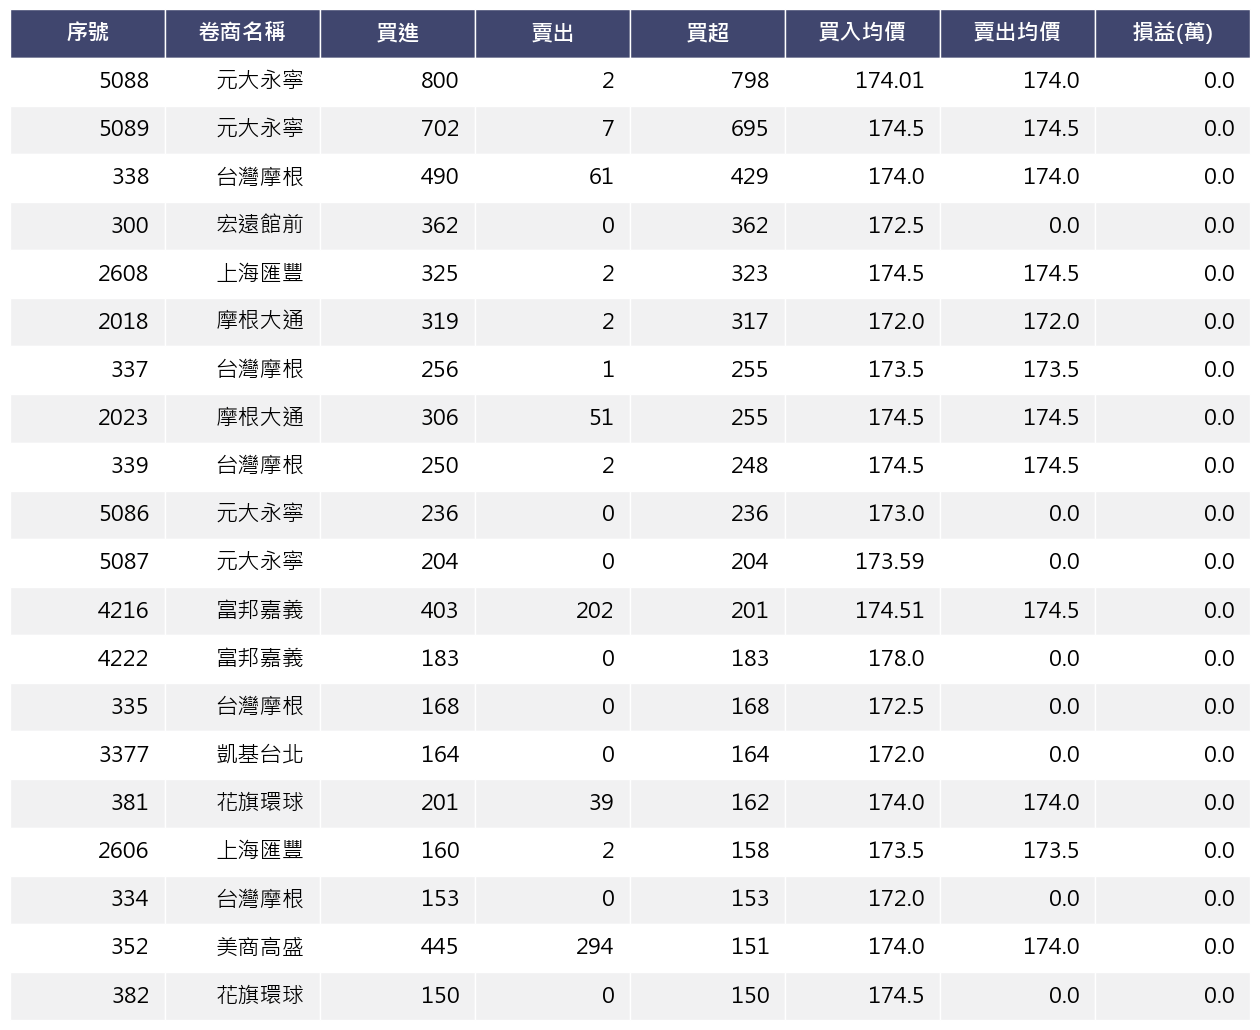

In [94]:
# 處理買賣超數據並創建圖表
for index in range(len(data_list)):
    data_list[index]["買進"] = int(data_list[index]["買進"])
    data_list[index]["賣出"] = int(data_list[index]["賣出"])
    data_list[index]["買超"] = data_list[index]["買進"] - data_list[index]["賣出"]
    if data_list[index]["買進"]:
        data_list[index]["買入均價"] = round(data_list[index]["買進價格"] / data_list[index]["買進"], 2)
    else:
        data_list[index]["買入均價"] = 0.0
    if data_list[index]["賣出"]:
        data_list[index]["賣出均價"] = round(data_list[index]["賣出價格"] / data_list[index]["賣出"], 2)
    else:
        data_list[index]["賣出均價"] = 0.0
    data_list[index]["損益(萬)"] = 0.0
    del data_list[index]['買進價格']
    del data_list[index]['賣出價格']
    del data_list[index]['價格']
    if data_list[index]["買超"] >= 0:
        data_list_positive.append(data_list[index])
    else:
        data_list_negative.append(data_list[index])

data_list_positive.sort(key=lambda x:x['買超'], reverse=True)
data_list_negative.sort(key=lambda x:x['買超'])

# 檢查 pandas 是否可用，創建 DataFrame 或使用原生數據結構
if pandas_available and pd is not None:
    try:
        df_positive = pd.DataFrame(data_list_positive)
        df_negative = pd.DataFrame(data_list_negative)
        df = pd.concat([df_positive, df_negative], axis=1)
        print("✅ 使用 pandas DataFrame 創建表格")
    except Exception as e:
        print(f"❌ DataFrame 創建失敗: {e}")
        df = None
else:
    df = None
    print("❌ pandas 不可用，跳過 DataFrame 操作")

# 以下是繪圖用 
def render_mpl_table(data, col_width=1.0, row_height=0.625, font_size=16,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        # 如果 data 是 DataFrame，使用其 shape；否則假設是列表
        if hasattr(data, 'shape'):
            size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        else:
            # 處理非 DataFrame 的情況
            rows = len(data) if data else 20
            cols = len(data[0]) if data and len(data) > 0 else 6  # 假設 6 列
            size = (np.array([cols, rows]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    # 處理表格數據
    if hasattr(data, 'values') and hasattr(data, 'columns'):
        # pandas DataFrame
        cell_text = data.values
        col_labels = data.columns
    else:
        # 原生 Python 數據結構
        if data_list_positive:
            # 創建表格數據
            headers = list(data_list_positive[0].keys()) if data_list_positive else []
            cell_text = []
            for item in data_list_positive[:20]:  # 只顯示前20個
                cell_text.append([str(item.get(col, '')) for col in headers])
            col_labels = headers
        else:
            cell_text = [['無數據']]
            col_labels = ['狀態']

    mpl_table = ax.table(cellText=cell_text, bbox=bbox, colLabels=col_labels, **kwargs)

    mpl_table.set_fontsize(font_size)
    mpl_table.auto_set_font_size(False)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


def get_table(ax):
    table = None
    for child in ax.get_children():
        if isinstance(child, matplotlib.table.Table):
            table = child
            return table
    return table


def set_row_edge_color(ax, row, color):
    table = get_table(ax)
    for k, cell in six.iteritems(table._cells):
        if (k[0] == row):
            cell.set_edgecolor(color)

# 創建表格
if df is not None:
    ax = render_mpl_table(df[:20], header_columns=0, col_width=2.0)
else:
    # 使用原生數據創建表格
    ax = render_mpl_table(data_list_positive[:20], header_columns=0, col_width=2.0)

plt.show()